### Packages Import

In [1]:
import pandas as pd
import numpy as np
import emoji

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns; sns.set()
%matplotlib inline

### Upload Data

In [2]:
train_df = pd.read_csv('train_E6oV3lV.csv')

In [3]:
test_df = pd.read_csv('test_tweets_anuFYb8.csv')

* ### Analyze Training Data

In [4]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
train_df.shape

(31962, 3)

In [6]:
len(train_df.id.unique())

31962

In [7]:
train_df.drop('id', axis=1, inplace=True)

In [8]:
train_df.tweet[0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

* ### Analyze Testing Data

In [9]:
test_df.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [10]:
test_df.shape

(17197, 2)

In [11]:
len(test_df.id.unique())

17197

In [12]:
test_df.drop('id', axis=1, inplace=True)

In [13]:
test_df.tweet[0]

'#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ\x80¦ '

## Exploratory Data Analysis

* ### Target Variable

In [14]:
labels_dict = {1: 'Negative (Racist/Sexist)', 0: 'Positive'}

train_df['label_category'] = train_df.label.map(labels_dict)
train_df.head(2)

,label,tweet,label_category
0,0,@user when a father is dysfunctional and is s...,Positive
1,0,@user @user thanks for #lyft credit i can't us...,Positive


Just as a note, we can see that **users** have been **anonymized**, so they do not provide any information within our analysis.

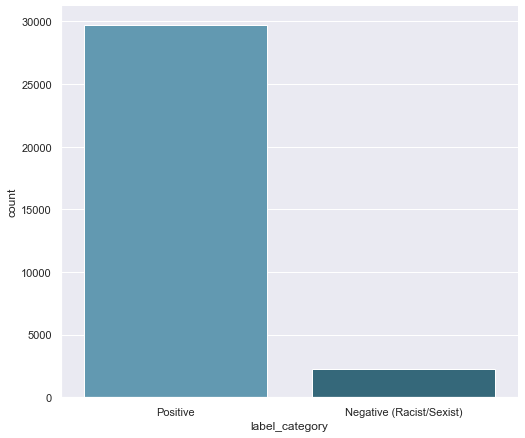

In [15]:
sns.catplot(x       = 'label_category', 
            data    = train_df, 
            kind    = 'count', 
            height  = 6, 
            aspect  = 1.2, 
            palette = 'PuBuGn_d')
plt.show();

We can see that the dataset is totally imbalanced, which may jeopardize the results of our model by creating false positive or negative. We will assess it when building and evaluating our model.

* ### Input Features

We computed some basic statistics on the tweets' text in order to analyze it. For that we created the class StatisticsText. (Got the idea from Bert Carremans' article on Sentiment Analysis with Text Mining) 

In [16]:
class StatisticsText(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet)) # Find all the patterns within the tweet text and obtain the count
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):    
        
        count_words    = X.apply(lambda x: self.count_regex(r'\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital  = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x)) # 2-or-more-length words on capital letter
        count_marks    = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_links    = X.apply(lambda x: self.count_regex(r'http.?://[^\s]?', x))
        count_emojis   = X.apply(lambda x: self.count_regex(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', x))
        
       # count_emojis   = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words'   : count_words,
                           'count_hashtags': count_hashtags,
                           'count_capital' : count_capital,
                           'count_marks'   : count_marks,
                           'count_links'   : count_links,
                           'count_emojis'  : count_emojis})
        
        return df

In [17]:
stats = StatisticsText()

In [18]:
df_eda = stats.fit_transform(train_df['tweet'])
df_eda.head(2)

,count_words,count_hashtags,count_capital,count_marks,count_links,count_emojis
0,18,1,0,0,0,0
1,21,3,0,0,0,0


In [19]:
df_eda.shape

(31962, 6)

In [20]:
stats = StatisticsText()

df_eda = stats.fit_transform(train_df['tweet'])

# Add label categories to the df with the data statistics
df_eda['label_category'] = train_df.label_category

We will create two functions that show the presence and distribution of each type of element in the tweet (words, hashtags, capital letters, question and exclamation marks, links and emojis).

In [21]:
def show_count(df, col):
    
    print('Descriptive stats for {}:'.format(col))
    print('-' * (len(col) + 22))
    print(df.groupby('label_category')[col].describe())
    
    bins  = np.arange(df[col].min(), 
                      df[col].max() + 1)
    
    graph = sns.FacetGrid(df, 
                          col     = 'label_category', 
                          height  = 5, 
                          hue     = 'label_category', 
                          palette = 'PuBuGn_d')
    
    graph = graph.map_dataframe(sns.histplot, 
                                col, 
                                kde  = False, 
                                bins = bins)
    plt.show()

In [22]:
def show_distribution(df, col):
    
    bins  = np.arange(df[col].min(), 
                      df[col].max() + 1)
    
    graph = sns.FacetGrid(df, 
                          col     = 'label_category', 
                          height  = 5, 
                          hue     = 'label_category', 
                          palette = 'PuBuGn_d')
    
    graph = graph.map(sns.distplot, 
                      col, 
                      kde       = False, 
                      norm_hist = True, 
                      bins      = bins)
    plt.show()

* **Count and distribution of words:**

Descriptive stats for count_words:
---------------------------------
                            count       mean       std  min   25%   50%   75%  \
label_category                                                                  
Negative (Racist/Sexist)   2242.0  14.453613  5.209218  2.0  11.0  14.0  18.0   
Positive                  29720.0  13.838190  5.866543  2.0   9.0  13.0  18.0   

                           max  
label_category                  
Negative (Racist/Sexist)  33.0  
Positive                  59.0  


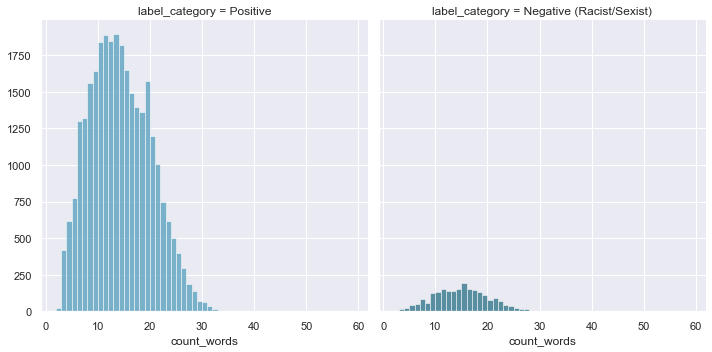

In [23]:
show_count(df_eda, 'count_words')

/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


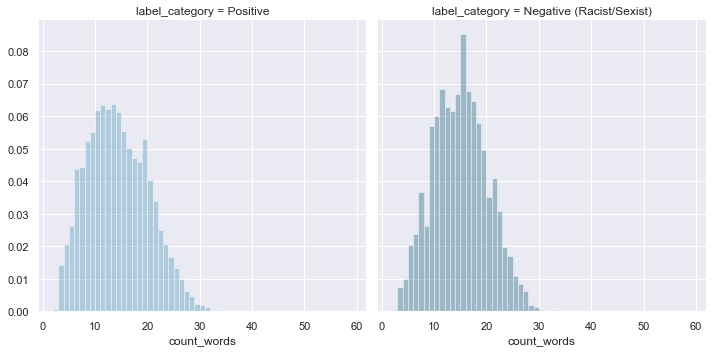

In [24]:
show_distribution(df_eda, 'count_words')

* **Count and distribution of hashtags:**

Descriptive stats for count_hashtags:
------------------------------------
                            count      mean       std  min  25%  50%  75%  \
label_category                                                              
Negative (Racist/Sexist)   2242.0  2.138715  2.063241  0.0  0.0  2.0  3.0   
Positive                  29720.0  2.405821  2.530931  0.0  0.0  2.0  4.0   

                           max  
label_category                  
Negative (Racist/Sexist)  14.0  
Positive                  20.0  


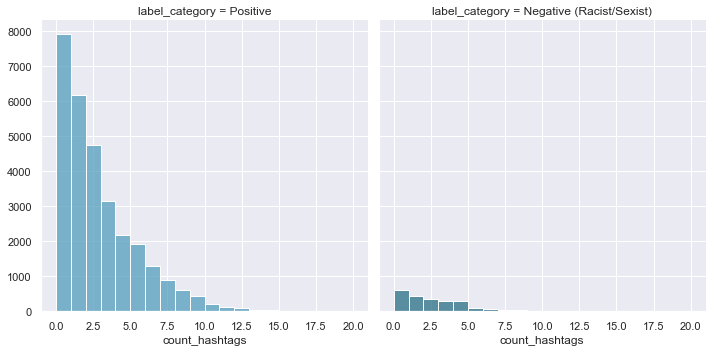

In [25]:
show_count(df_eda, 'count_hashtags')

/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


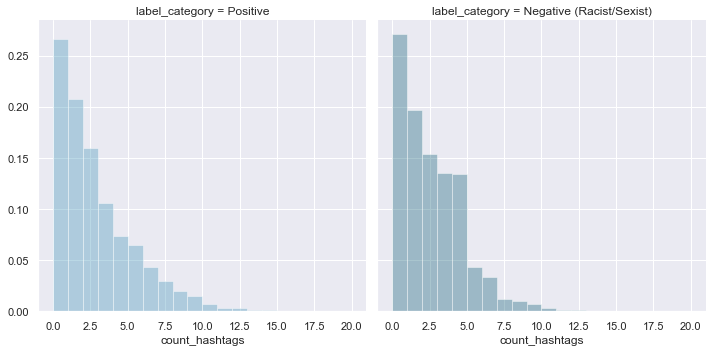

In [26]:
show_distribution(df_eda, 'count_hashtags')

* **Count and distribution of words in capital letter:**

Descriptive stats for count_capital:
-----------------------------------
                            count  mean  std  min  25%  50%  75%  max
label_category                                                       
Negative (Racist/Sexist)   2242.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
Positive                  29720.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


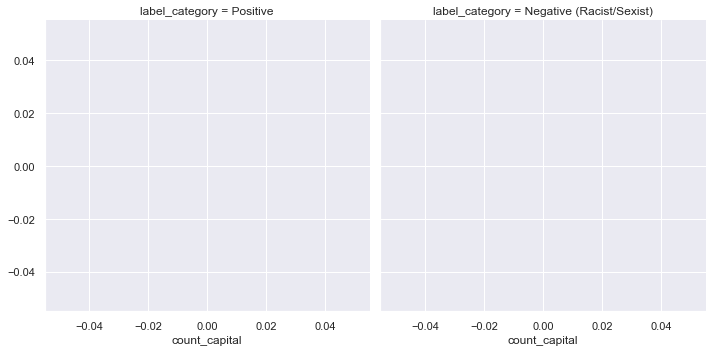

In [27]:
show_count(df_eda, 'count_capital')

/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


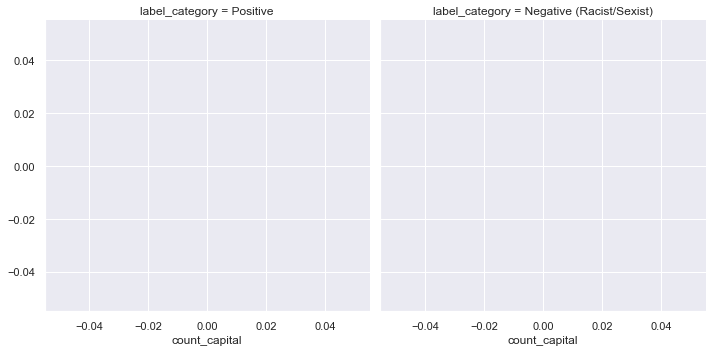

In [28]:
show_distribution(df_eda, 'count_capital')

* **Count and distribution of question and exclamation marks:**

Descriptive stats for count_marks:
---------------------------------
                            count      mean       std  min  25%  50%  75%  \
label_category                                                              
Negative (Racist/Sexist)   2242.0  0.359946  0.728254  0.0  0.0  0.0  1.0   
Positive                  29720.0  0.553264  1.192071  0.0  0.0  0.0  1.0   

                           max  
label_category                  
Negative (Racist/Sexist)   8.0  
Positive                  58.0  


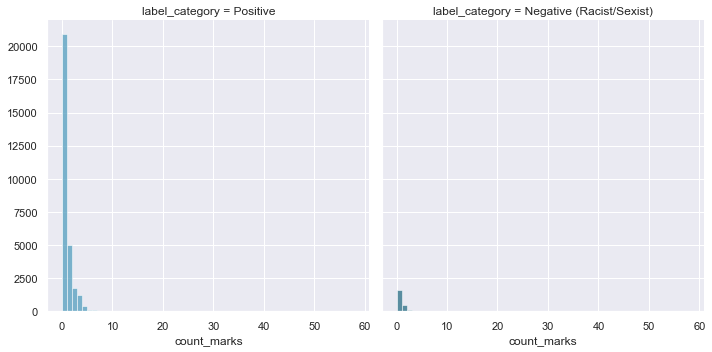

In [29]:
show_count(df_eda, 'count_marks')

/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


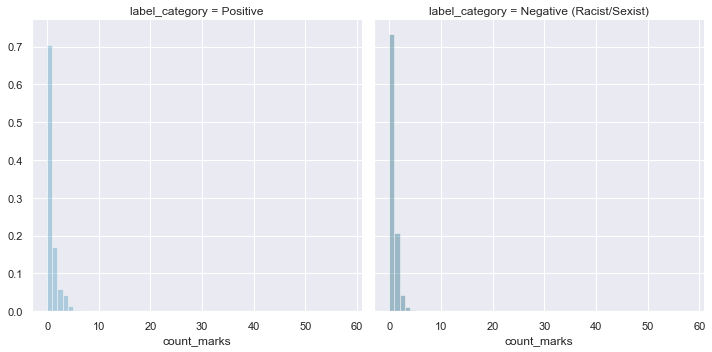

In [30]:
show_distribution(df_eda, 'count_marks')

* **Count and distribution of links:**

Descriptive stats for count_links:
---------------------------------
                            count  mean  std  min  25%  50%  75%  max
label_category                                                       
Negative (Racist/Sexist)   2242.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
Positive                  29720.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


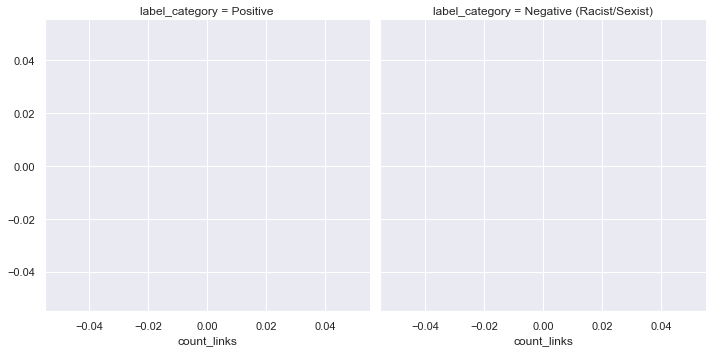

In [31]:
show_count(df_eda, 'count_links')

/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


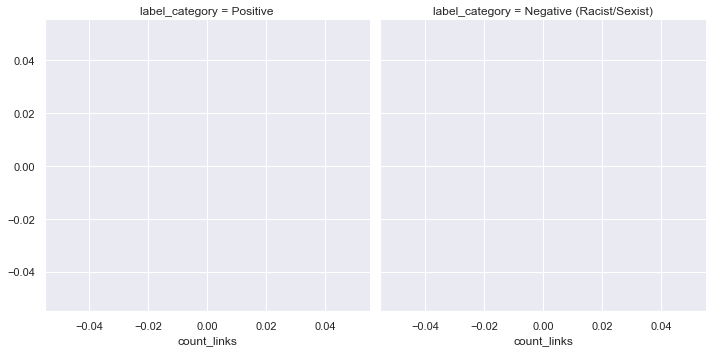

In [32]:
show_distribution(df_eda, 'count_links')

* **Count and distribution of emojis:**

Descriptive stats for count_emojis:
----------------------------------
                            count      mean       std  min  25%  50%  75%  max
label_category                                                                
Negative (Racist/Sexist)   2242.0  0.002676  0.051674  0.0  0.0  0.0  0.0  1.0
Positive                  29720.0  0.020458  0.152324  0.0  0.0  0.0  0.0  4.0


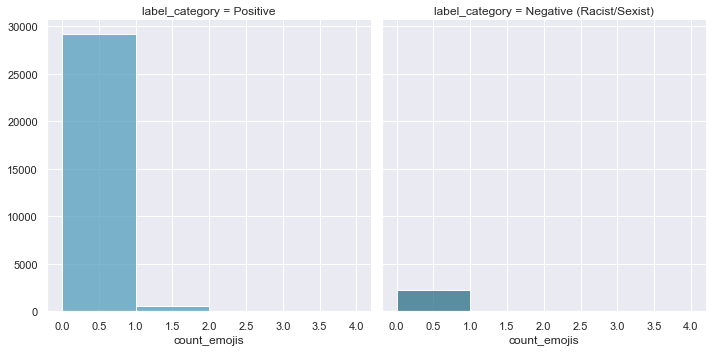

In [33]:
show_count(df_eda, 'count_emojis')

/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


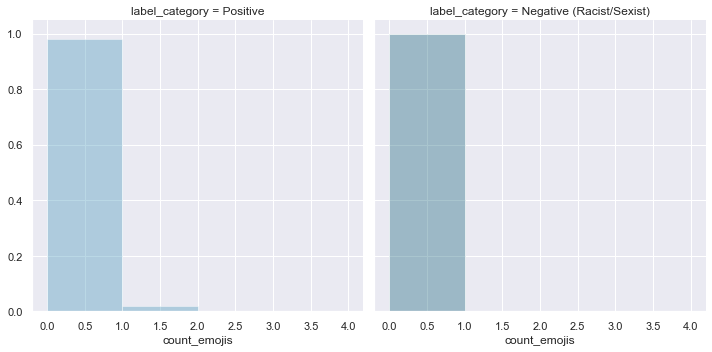

In [34]:
show_distribution(df_eda, 'count_emojis')

### Clean Data and Create Tokenizer


We will remove all the non-word characters, convert to lowercase (although as we saw before, there are no capital words) and temporarily store emoticons to the end of the tweet.

In [35]:
def preprocessor(text):
    
    # Find emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    
    # Remove all non-word characters, convert to lower case and store emoticons to the end
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    
    return text

In [36]:
train_df['tweet'] = train_df['tweet'].apply(preprocessor)

In [37]:
train_df['tweet'][0]

' user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run'

## Training model - Multinomial NB

* #### Separate training and validation sets

In [38]:
X_train = train_df.loc[:25000, 'tweet'].values
y_train = train_df.loc[:25000, 'label'].values

X_valid = train_df.loc[25000:, 'tweet'].values
y_valid = train_df.loc[25000:, 'label'].values

* #### Create Tokenizer and Tokenizer + Stemmer Functions

In [39]:
def tokenizer(text):
    return text.split()

In [40]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

* #### Create Pipeline

In [41]:
stop = stopwords.words('english')

tfidf = TfidfVectorizer(strip_accents = None, 
                        lowercase     = False, 
                        preprocessor  = None)

param_grid = [{'vect__ngram_range': [(1,1)],
               'vect__stop_words' : [stop, None],
               'vect__tokenizer'  : [tokenizer, tokenizer_porter],
               'clf__alpha'       : [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1., 1.5]},
              
              {'vect__ngram_range': [(1,1)],
               'vect__stop_words' : [stop, None],
               'vect__tokenizer'  : [tokenizer, tokenizer_porter],
               'vect__use_idf'    : [False],
               'vect__norm'       : [None],
               'clf__alpha'       : [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1., 1.5]}]

In [42]:
tfidf = TfidfVectorizer(strip_accents = None, 
                        lowercase     = False, 
                        preprocessor  = None)

param_grid = {'vect__ngram_range': [(1,1)],
              'vect__stop_words' : [stop, None],
              'vect__tokenizer'  : [tokenizer, tokenizer_porter],
              'vect__use_idf'    : [True, False],
              'vect__norm'       : ['l1', 'l2', None],
              'clf__alpha'       : [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1., 1.5]}

In [43]:
multnb_tfidf = Pipeline([('vect', tfidf),
                         ('clf' , MultinomialNB())])

* #### Grid Search

In [44]:
grid_multnb_tfidf = GridSearchCV(multnb_tfidf, 
                                 param_grid, 
                                 cv      = 5, 
                                 verbose = 2,
                                 n_jobs  = -1)

In [45]:
grid_multnb_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 71.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 79.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9,
                                        1.0, 1.5],
                         'vect__ngram_range': [(1, 1)],
                         'vect__norm': ['l1', 'l2', None],
                         'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she

In [46]:
print('Best parameter set: %s ' % grid_multnb_tfidf.best_params_)

Best parameter set: {'clf__alpha': 0.5, 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each

* #### Check Results

In [47]:
clf = grid_multnb_tfidf.best_estimator_

pred_train = clf.predict(X_train)
pred_valid = clf.predict(X_valid)

In [48]:
print('Accuracy - Train: {:.3f}, Test: {:.3f}'.format(accuracy_score(y_train, pred_train), 
                                                      accuracy_score(y_valid, pred_valid)))
print('F-score  - Train: {:.3f}, Test: {:.3f}\n'.format(fbeta_score(y_train, pred_train, beta = 0.5), 
                                                        fbeta_score(y_valid, pred_valid, beta = 0.5)))
print('ROC-AUC  - Train: {:.3f}, Test: {:.3f}'.format(roc_auc_score(y_train, pred_train), 
                                                      roc_auc_score(y_valid, pred_valid)))

Accuracy - Train: 0.977, Test: 0.962
F-score  - Train: 0.821, Test: 0.746

ROC-AUC  - Train: 0.930, Test: 0.803


In [49]:
confusion_matrix(y_valid, pred_valid)

array([[6392,   82],
       [ 186,  302]])

### Predicting Category on the Test Data

In [50]:
test_df.head(2)

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...


In [51]:
test_df['tweet'] = test_df['tweet'].apply(preprocessor)

In [52]:
test_df['tweet'][0]

' studiolife aislife requires passion dedication willpower to find newmaterialsâ '

In [53]:
X_test = test_df.loc[:, 'tweet'].values

In [54]:
pred_test = clf.predict(X_test)

In [55]:
sample_submission = pd.read_csv('sample_submission_gfvA5FD.csv')

sample_submission.head(2)

,id,label
0,31963,0
1,31964,0


In [56]:
test_predictions = sample_submission
test_predictions['label'] = pred_test

test_predictions.head(2)

,id,label
0,31963,0
1,31964,0


In [ ]:
test_predictions.to_csv('test_predictions.csv', index = False)